In [1]:
from __future__ import annotations
import os

# When on Aura, it is important to first set CUDA_VISIBLE_DEVICES environment variable directly from notebook
# For available GPUs, see https://www.fi.muni.cz/tech/unix/aura.html.cs
# Must be done before any related package that leverages cuda is imported
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-56c53afb-6f08-5e5b-83fa-32fc6f09eeb0"
os.environ["TOKENIZERS_PARALLELISM"] = "FALSE"

import pandas as pd
from sec_certs.dataset import CCDataset
from shutil import copy
from pathlib import Path
from sec_certs.model.references.segment_extractor import ReferenceSegmentExtractor
from sec_certs.utils.nlp import prec_recall_metric
from sklearn.dummy import DummyClassifier
from sec_certs.utils.nlp import prec_recall_metric
from sec_certs.model.references.annotator_trainer import ReferenceAnnotatorTrainer
from sklearn.metrics import ConfusionMatrixDisplay
from sec_certs.utils.helpers import compute_heuristics_version
from rapidfuzz import fuzz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch


REPO_ROOT = Path(".").resolve()
DATASET_PATH = REPO_ROOT / "dataset/cc_final_run_may_23/dataset.json"
ANNOTATIONS_PATH = REPO_ROOT / "src/sec_certs/data/reference_annotations/manual_annotations/"

def replace_all(text: str, to_replce: set[str]) -> str:
    for i in to_replce:
        text = text.replace(i, "")
    return text

print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


# Load data

Enrich annotations with string similarity of cert. and referenced cert.

In [2]:
train_annotations = pd.read_csv(ANNOTATIONS_PATH / "train.csv")
valid_annotations = pd.read_csv(ANNOTATIONS_PATH / "valid.csv")
all_annotations = pd.concat([train_annotations, valid_annotations])
all_annotations = all_annotations[all_annotations.label != "None"].assign(label=lambda df: df.label.str.upper())

dset = CCDataset.from_json(DATASET_PATH)
all_certs = {x.dgst: x for x in dset.certs.values()}
dset.certs = {x.dgst: x for x in dset.certs.values() if x.dgst in all_annotations.dgst.unique()}

cert_id_to_name_mapping = {x.heuristics.cert_id: x.name for x in all_certs.values()}
all_annotations["referenced_cert_name"] = all_annotations["referenced_cert_id"].map(cert_id_to_name_mapping)
all_annotations["cert_name"] = all_annotations["dgst"].map(lambda x: dset[x].name)
all_annotations["cert_versions"] = all_annotations["cert_name"].map(compute_heuristics_version)
all_annotations = all_annotations.loc[all_annotations["referenced_cert_name"].notnull()].copy()
all_annotations["referenced_cert_versions"] = all_annotations["referenced_cert_name"].map(compute_heuristics_version)
all_annotations["cert_name_stripped_version"] = all_annotations.apply(lambda x: replace_all(x["cert_name"], x["cert_versions"]), axis=1)
all_annotations["referenced_cert_name_stripped_version"] = all_annotations.apply(lambda x: replace_all(x["referenced_cert_name"], x["referenced_cert_versions"]), axis=1)
all_annotations["name_similarity"] = all_annotations.apply(lambda x: fuzz.token_set_ratio(x["cert_name"], x["referenced_cert_name"]), axis=1)
all_annotations["name_similarity_stripped_version"] = all_annotations.apply(lambda x: fuzz.token_set_ratio(x["cert_name_stripped_version"], x["referenced_cert_name_stripped_version"]), axis=1)

## Retrieve segments

In [3]:
df = ReferenceSegmentExtractor()(dset.certs.values())
df = df.loc[df.label.notnull()].copy()
# label_mapping = {"COMPONENT_USED": "COMPONENT_SHARED", "RECERTIFICATION": "PREVIOUS_VERSION"}
# df.label = df.label.map(lambda x: label_mapping[x] if x in label_mapping else x)

Recovering reference segments: 100%|██████████| 151/151 [00:15<00:00, 10.05it/s]


I now have 151 in target mode


Recovering reference segments: 100%|██████████| 330/330 [00:06<00:00, 53.82it/s] 


I now have 330 in report mode
df_targets shape: (151, 4)
df_reports shape: (330, 4)


## Segment post-processing

In [4]:
def process_segment(segment: str, referenced_cert_id: str) -> str:
    segment = segment.replace(referenced_cert_id, "referenced product")
    return segment

df.segments = df.apply(lambda row: [process_segment(x, row.referenced_cert_id) for x in row.segments], axis=1)

## Train & evaluate the baseline classifier (majority class)

In [5]:
dummy_clf = DummyClassifier()
dummy_clf.fit(df.loc[df.split == "train", ["segments"]], df.loc[df.split == "train"].label)
y_pred_dummy = dummy_clf.predict(df.loc[df.split == "valid", ["segments"]])
print(classification_report(df.loc[df.split == "valid"].label, y_pred_dummy, zero_division=0))

                   precision    recall  f1-score   support

 COMPONENT_SHARED       0.00      0.00      0.00         2
   COMPONENT_USED       0.58      1.00      0.73        54
EVALUATION_REUSED       0.00      0.00      0.00        12
 PREVIOUS_VERSION       0.00      0.00      0.00         7
  RECERTIFICATION       0.00      0.00      0.00        18

         accuracy                           0.58        93
        macro avg       0.12      0.20      0.15        93
     weighted avg       0.34      0.58      0.43        93



## Train & evaluate the transformer

config.json not found in HuggingFace Hub.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 29360
  Num epochs = 1
  Total optimization steps = 1835
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1835 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Internal evaluation (of model working on individual segments)
{'precision': 0.6876790830945558, 'recall': 0.6876790830945558}
Actual evaluation after ensemble soft voting
{'precision': 0.8021978021978022, 'recall': 0.8021978021978022}
                   precision    recall  f1-score   support

 COMPONENT_SHARED       0.00      0.00      0.00         0
   COMPONENT_USED       0.94      0.88      0.91        58
EVALUATION_REUSED       0.25      0.75      0.38         4
 PREVIOUS_VERSION       0.86      0.50      0.63        12
  RECERTIFICATION       0.94      0.89      0.92        19

         accuracy                           0.83        93
        macro avg       0.60      0.60      0.57        93
     weighted avg       0.90      0.83      0.85        93



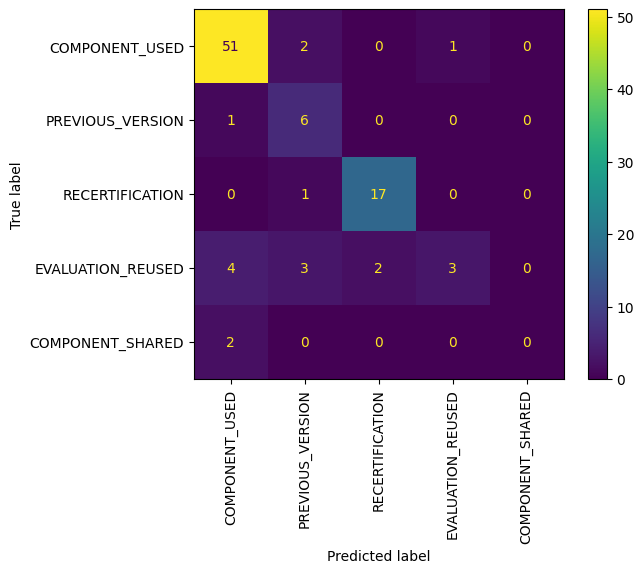

In [6]:
trainer = ReferenceAnnotatorTrainer.from_df(df, prec_recall_metric, mode="training")
trainer.train()
trainer.evaluate()

annotator = trainer.clf
df_predicted = annotator.predict_df(df)

# # Refine predictions with rule that transforms labels to PREVIOUS_VERSION if name_similarity_stripped_version > 95 and y_pred is not PREVIOUS_VERSION or RECERTIFICATION
# # TODO: This should be moved to the model layer
df_predicted = df_predicted.merge(all_annotations.loc[:, ["dgst", "referenced_cert_id", "name_similarity_stripped_version"]], on=["dgst", "referenced_cert_id"])
df_predicted.loc[(df_predicted.name_similarity_stripped_version > 95) & ((df_predicted.y_pred != "RECERTIFICATION") & (df_predicted.y_pred != "PREVIOUS_VERSION")), ["y_pred"]] = "PREVIOUS_VERSION"
df_predicted["correct"] = df_predicted["label"] == df_predicted["y_pred"]

# Dump bad predictions to json
df_predicted.loc[df_predicted.correct == False].to_json("/var/tmp/xjanovsk/certs/sec-certs/dataset/annotator_errors.json", orient="records", indent=4)

print(classification_report(df_predicted.loc[df_predicted.split == "valid", ["y_pred"]], df_predicted.loc[df_predicted.split == "valid", ["label"]], zero_division=0))

# Print confusion matrix
ConfusionMatrixDisplay.from_predictions(df_predicted.loc[df_predicted.split == "valid", ["label"]], df_predicted.loc[df_predicted.split == "valid", ["y_pred"]], labels=df_predicted.label.unique(), display_labels=df_predicted.label.unique(), xticks_rotation=90)

## Train classifier enhanced with feature of name similarity

In [7]:
df_predicted = df_predicted.join(pd.DataFrame(df_predicted.y_proba.tolist(), index=df_predicted.index))
df_predicted = df_predicted.rename(columns={i: f"proba_{i}" for i in range(0, 5)})

clf = RandomForestClassifier()
clf.fit(df_predicted[df_predicted.split == "train"][["proba_0", "proba_1", "proba_2", "proba_3", "proba_4", "name_similarity_stripped_version"]], df_predicted[df_predicted.split == "train"].label)
df_predicted["clf_name_similarity_label"] = clf.predict(df_predicted[["proba_0", "proba_1", "proba_2", "proba_3", "proba_4", "name_similarity_stripped_version"]])
print(classification_report(df_predicted[df_predicted.split == "valid"].label, df_predicted[df_predicted.split == "valid"].clf_name_similarity_label, zero_division=0))

                   precision    recall  f1-score   support

 COMPONENT_SHARED       0.00      0.00      0.00         2
   COMPONENT_USED       0.85      0.93      0.88        54
EVALUATION_REUSED       0.75      0.25      0.38        12
 PREVIOUS_VERSION       0.36      0.57      0.44         7
  RECERTIFICATION       0.89      0.94      0.92        18

         accuracy                           0.80        93
        macro avg       0.57      0.54      0.52        93
     weighted avg       0.79      0.80      0.77        93

